<img src="Dados/nvd.png" width="900">

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

In [103]:
from google.colab import drive
drive.mount('/content/drive')
arquivo = '/content/drive/MyDrive/Pos/Atividades/Dados/NVDA.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = pd.read_csv(arquivo, index_col="Date", parse_dates=["Date"])
print(dataset.head())

                           Adj Close     Close      High       Low      Open  \
Date                                                                           
2004-01-02 00:00:00+00:00   0.176398  0.192333  0.199083  0.192333  0.196417   
2004-01-05 00:00:00+00:00   0.182130  0.198583  0.199917  0.193500  0.195250   
2004-01-06 00:00:00+00:00   0.189544  0.206667  0.209417  0.197083  0.198000   
2004-01-07 00:00:00+00:00   0.191225  0.208500  0.209500  0.202917  0.204333   
2004-01-08 00:00:00+00:00   0.191913  0.209250  0.212083  0.207250  0.211083   

                               Volume  
Date                                   
2004-01-02 00:00:00+00:00   436416000  
2004-01-05 00:00:00+00:00   575292000  
2004-01-06 00:00:00+00:00  1093344000  
2004-01-07 00:00:00+00:00   673032000  
2004-01-08 00:00:00+00:00   433752000  


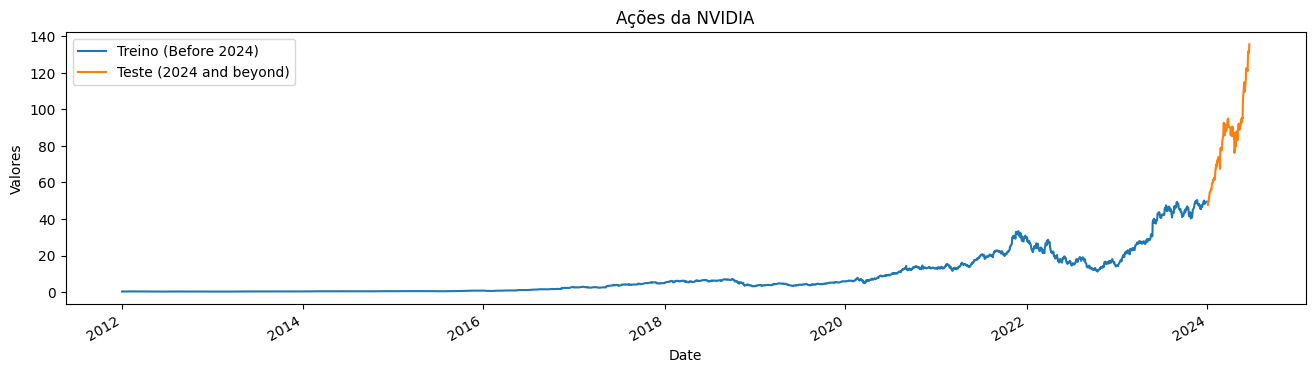

In [ ]:
tstart = 2012
tend = 2023

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "Close"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "Close"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Treino (Before {tend+1})", f"Teste ({tend+1} and beyond)"])
    plt.title("Ações da NVIDIA")
    plt.ylabel('Valores')
    plt.show()

train_test_plot(dataset,tstart,tend)

In [ ]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "Close"].values
    test = dataset.loc[f"{tend+1}":, "Close"].values
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)

In [ ]:
print(len(training_set))

3018


In [ ]:
print(len(test_set))

117


In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 120
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [ ]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [ ]:
print(len(X_train))

2898


In [ ]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()
Model: "sequential"

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 125)                 │          63,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - loss: 0.0035
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - loss: 5.4024e-04
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 192ms/step - loss: 4.2714e-04
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 22s 208ms/step - loss: 3.6043e-04
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - loss: 3.1736e-04
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 22s 214ms/step - loss: 2.8687e-04
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 189ms/step - loss: 2.6385e-04
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step - loss: 2.4590e-04
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - loss: 2.3167e-04
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - loss: 2.2013e-04
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - loss: 2.1055e-04
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 22s 166ms/step - loss: 2.0244e-04
Epoch 13/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - loss: 1.9547e-04
Epoch 14/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - loss: 1.

In [ ]:
dataset_total = dataset.loc[:,"Close"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


In [ ]:
print(predicted_stock_price)

[[ 49.467762]
 [ 48.850098]
 [ 48.159065]
 [ 47.93763 ]
 [ 48.35708 ]
 [ 50.176247]
 [ 51.76612 ]
 [ 53.311005]
 [ 54.430202]
 [ 54.97207 ]
 [ 55.99883 ]
 [ 56.38147 ]
 [ 57.02182 ]
 [ 58.475975]
 [ 59.384586]
 [ 59.959545]
 [ 60.928745]
 [ 61.56453 ]
 [ 61.58736 ]
 [ 62.195755]
 [ 62.65565 ]
 [ 62.283405]
 [ 62.704193]
 [ 64.42624 ]
 [ 66.98474 ]
 [ 67.99716 ]
 [ 69.40407 ]
 [ 69.941   ]
 [ 71.326546]
 [ 72.13187 ]
 [ 72.4602  ]
 [ 73.38919 ]
 [ 73.288414]
 [ 73.11203 ]
 [ 71.43293 ]
 [ 69.39097 ]
 [ 73.35236 ]
 [ 76.02728 ]
 [ 77.81037 ]
 [ 78.64091 ]
 [ 78.53948 ]
 [ 79.026505]
 [ 80.716   ]
 [ 83.07325 ]
 [ 84.79009 ]
 [ 87.004944]
 [ 90.07493 ]
 [ 89.45519 ]
 [ 88.064285]
 [ 89.87654 ]
 [ 90.44931 ]
 [ 89.370155]
 [ 88.56409 ]
 [ 88.299065]
 [ 88.560616]
 [ 89.18154 ]
 [ 90.06459 ]
 [ 91.92042 ]
 [ 93.37756 ]
 [ 93.10795 ]
 [ 91.79229 ]
 [ 90.94637 ]
 [ 90.39172 ]
 [ 89.63127 ]
 [ 88.9543  ]
 [ 87.1504  ]
 [ 87.04338 ]
 [ 86.64217 ]
 [ 85.63774 ]
 [ 85.85407 ]
 [ 87.71284 ]
 [ 87.

In [ ]:
def plot_predictions(test, predicted):
    plt.plot(test, color="blue", label="Fechamento real (2023)")
    plt.plot(predicted, color="red", label="Previsão Para (2024)  ")
    plt.title("Fechamentos ações NVIDIA")
    plt.xlabel("Tempo")
    plt.ylabel("Preços das ações")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

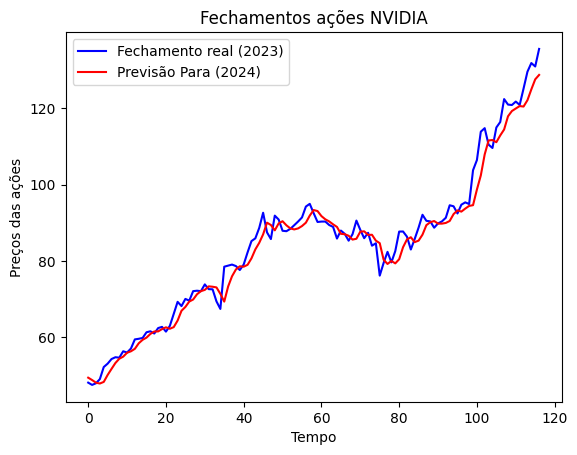

In [ ]:
plot_predictions(test_set,predicted_stock_price)

In [ ]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 3.40.
